In [1]:
from utils import DeepWalk
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

# A primer: vanilla DeepWalk on Karate Club graph

In [2]:
G = nx.karate_club_graph()

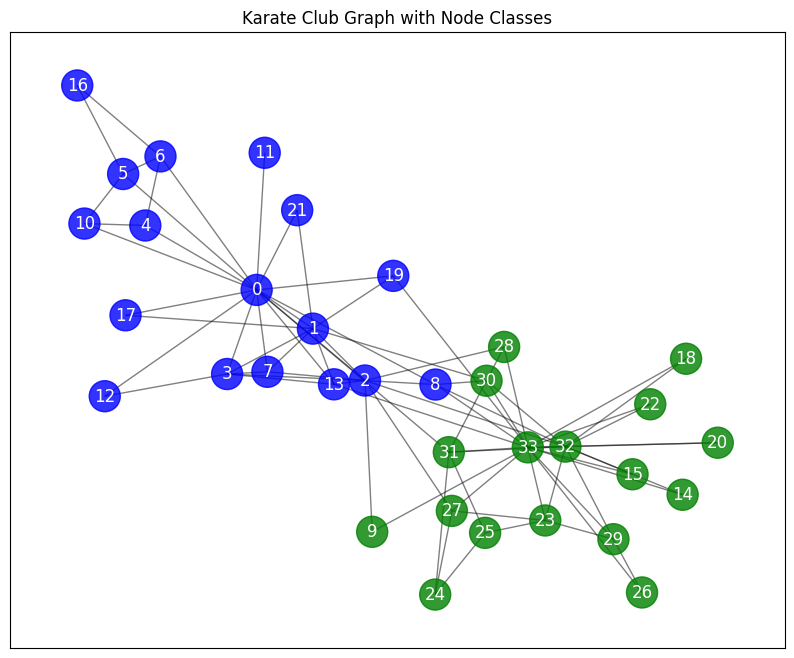

In [3]:
club_colors = {
    'Mr. Hi': 'blue',
    'Officer': 'green'
}

node_colors = [club_colors[G.nodes[node]['club']] for node in G.nodes]

pos = nx.spring_layout(G)  

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')

plt.title("Karate Club Graph with Node Classes")
plt.show()

In [13]:
model = DeepWalk(G, 3, 2, 100, 10, 5e-5)

In [14]:
model.main_loop()

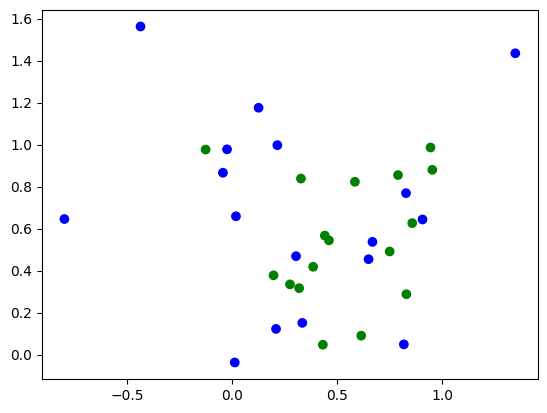

In [15]:
plt.scatter(model.Phi[:,0],model.Phi[:,1], color=node_colors)